In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from tqdm.notebook import tqdm
import json
import glob
import os
import xarray as xr
from shapely.geometry import shape
import dask
import dask.dataframe as dd
import dask.array as da

In [2]:
client = dask.distributed.Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59129,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59853,Total threads: 1
Dashboard: http://127.0.0.1:59858/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:59141,


# Conversion to netcdf didn't work (below) - use dask DataFrame

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from tqdm.notebook import tqdm
import json
import glob
import os
import xarray as xr
from shapely.geometry import shape
import dask
import dask.dataframe as dd
import dask.array as da

In [15]:
def parse_item(item_fn):
    df = pd.read_csv(item_fn, low_memory=True)
    # coords = shape(json.loads(df['Coordinates'][0].replace("'", '"')))
    coords = df['Coordinates'][0].replace("'", '"') # replace ' with " to make it a valid wkt string
    product = df['Name'][4]
    location_name = df['Name'][0]

    if 'resultType' in df.columns:
        if df['resultType'].iloc[-1] == 'modelled':
            return None
    else:
        times = pd.to_datetime(df['dateTime'].iloc[9:].reindex(), utc=True)
        variable = df['result'].iloc[9:].reindex().apply(float)

        cleaned_dataset = pd.DataFrame({
            'time': pd.Series(times),
            f'values': pd.Series(variable, dtype=float),
            'location': location_name,
            'product': product,
            'geometry': coords
        }).reset_index().drop('index', axis='columns')#.set_index('time')
        
        return dd.from_pandas(cleaned_dataset, chunksize=5000)
        # return cleaned_dataset

In [16]:
r = parse_item('../data/rest/1/18.csv')
r

,time,values,location,product,geometry
npartitions=1,,,,,
0,"datetime64[ns, UTC]",float64,object,object,object
3731,...,...,...,...,...


In [17]:
r.head(10)

,time,values,location,product,geometry
0,1995-05-11 19:00:00+00:00,1362.11,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
1,1995-05-12 19:00:00+00:00,1419.42,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
2,1995-05-13 19:00:00+00:00,1171.44,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
3,1995-05-14 19:00:00+00:00,1382.57,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
4,1995-05-15 19:00:00+00:00,1650.08,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
5,1995-05-16 19:00:00+00:00,1129.19,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
6,1995-05-17 19:00:00+00:00,1096.38,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
7,1995-05-18 19:00:00+00:00,1267.59,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
8,1995-05-19 19:00:00+00:00,1488.19,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."
9,1995-05-20 19:00:00+00:00,1192.78,Gray Reef Dam,Lake/Reservoir Storage,"{""type"": ""Point"", ""coordinates"": [-106.6989, 4..."


In [18]:
cleaned_datasets = []
catalog_record_fns = glob.glob("../data/rest/*")
for catalog_record_fn in tqdm(catalog_record_fns):
    catalog_item_fns = glob.glob(os.path.join(catalog_record_fn, "*.csv"))
    for catalog_item_fn in catalog_item_fns:
        catalog_item = int(os.path.split(catalog_item_fn)[-1].split('.')[0])
        catalog_record = int(os.path.split(catalog_record_fn)[-1])

        cleaned_dataset = parse_item(catalog_item_fn)
        if cleaned_dataset is not None:
            cleaned_dataset['catalog_item'] = catalog_item
            cleaned_dataset['catalog_record'] = catalog_record

            cleaned_datasets.append(cleaned_dataset)

  0%|          | 0/166 [00:00<?, ?it/s]

/var/folders/2y/h464qnw52wq0lwvhs1s03dy40000gp/T/ipykernel_12863/3253778103.py:9: DtypeWarning: Columns (0,1,2,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  cleaned_dataset = parse_item(catalog_item_fn)
/var/folders/2y/h464qnw52wq0lwvhs1s03dy40000gp/T/ipykernel_12863/3253778103.py:9: DtypeWarning: Columns (0,1,2,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  cleaned_dataset = parse_item(catalog_item_fn)
/var/folders/2y/h464qnw52wq0lwvhs1s03dy40000gp/T/ipykernel_12863/3253778103.py:9: DtypeWarning: Columns (0,1,2,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  cleaned_dataset = parse_item(catalog_item_fn)
/var/folders/2y/h464qnw52wq0lwvhs1s03dy40000gp/T/ipykernel_12863/3253778103.py:9: DtypeWarning: Columns (0,1,2,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  cleaned_dataset = parse_item(catalog_item_fn)
/var/folders/2y/h464qnw52wq0lwvhs1s03dy40000gp/T/ipy

In [19]:
merged = dd.multi.concat(cleaned_datasets).reset_index().drop('index', axis='columns')
merged

,time,values,location,product,geometry,catalog_item,catalog_record
npartitions=1212,,,,,,,
,"datetime64[ns, UTC]",float64,object,object,object,int64,int64
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [20]:
merged.to_csv('../data/US-RISE/*.csv', index=False)

['/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0000.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0001.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0002.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0003.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0004.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0005.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0006.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0007.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0008.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0009.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0010.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/../data/US-RISE/0011.csv',
 '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/

# Parse the products available 

In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
fn = r'../data/US-RISE-metadata.csv'
df = pd.read_csv(fn).drop('Unnamed: 0', axis=1)
df.head()

,name,product,geometry
0,Lake Nasworthy and Dam,Elevation,POINT (-100.4781 31.3886)
1,Lake Nasworthy and Dam,Release - Total,POINT (-100.4781 31.3886)
2,Lake Nasworthy and Dam,Storage,POINT (-100.4781 31.3886)
3,Merritt Reservoir and Dam,Canal Flow,POINT (-100.8722 42.635)
4,Merritt Reservoir and Dam,Elevation,POINT (-100.8722 42.635)


In [4]:
# If the name is preceded by `Q_`, that product is a bit sketchy (say diversion, which by itself 
# is unclear, about where the diversion is happenning), and requires extra attention later.
possible_products = {
    'water_elevation': r'Elevation',                                            # Water level/elevation
    'storage': r'Storage',                                                      # Total storage
    'storage_change': r'Change In Storage',                                     # ∆S
    'surf_area': r'Area',                                                       # Surface area
    'inflow': r'Inflow',                                                        # Inflow
    'outflow': r'Release - Total',                                              # Total outflow
    'evaporation': r'Evaporation',                                              # Evaporation
    'precipitation': r'Precipitation',                                          # Precipitation

    'outflow_spillway': r'Release - Spillway',                                  # Spillway outflow
    'outflow_outlet': r'Release - Outlet',                                      # Outlet outflow
    'outflow_powerplant': r'(Release - Powerplant)|(Release - .+Powerplant)',   # Powerplant outflow
    'Q_outflow_bypass': r'Release - Bypass',                                    # Bypass outflow
    'Q_outflow_blockrelease': r'Block Release',                                 # Bypass outflow
    'Q_bank_storage': r'Bank Storage',                                          # Bypass outflow
    'canal_flow': r'(Canal Flow)|(Release - .+ Canal)',                         # Release to canal
    'temperature': r'Water Temperature',                                        # Water Temperature
    
    'Q_full_natural_flow': r'Full Natural Flow',                                # Inflow??
    'Q_side_inflow': r'Side Inflow',                                            # Inflow??
    'Q_diversion': r'Diversion',                                                # Diversion? similar to canal flow?
    'Q_streamflow': r'Streamflow',                                              # Streamflow ? not sure what this means in terms of reservoir
    'Q_stream_gage_ht': r'Stream Gage Height',                                  # Stream gage height
}

# loop through rows, see where which of the above variables are present
# If present, identify them and append to list. If not, add None/nan
# All the extra variables are printed out for further classification

def parse_product(row):
    """parses the product string to identify which product is it

    Args:
        row (pd.DataFrame): single row of dataframe containing the `product` column
    """
    product = row['product'].strip()
    
    identified_product = 'UNIDENTIFIED'

    for product_name in possible_products:
        product_re = possible_products[product_name]
        if re.match(product_re, product):
            identified_product = product_name

    return identified_product


df['parsed_product'] = df.apply(parse_product, axis='columns')
print(f"{len(df[df['parsed_product'] == 'UNIDENTIFIED'])*100/len(df):.2f}% remaining unidentified")
df[df['parsed_product'] == 'UNIDENTIFIED'].head(50)

1.00% remaining unidentified


,name,product,geometry,parsed_product
64,Pecos River near Acme,Number of days dry,POINT (-104.37362 33.57195),UNIDENTIFIED
67,Brantley Lake and Dam,Estimated TX Settlement Release,POINT (-104.3814 32.5442),UNIDENTIFIED
75,Lake Sumner and Dam,Additional Water needed at Sumner for ESA,POINT (-104.3924 34.62884),UNIDENTIFIED
82,Lake Sumner and Dam,Sumner and VCP ESA Release,POINT (-104.3924 34.62884),UNIDENTIFIED
158,Heron Reservoir and Dam,Average San Juan Chama Inflow Volume,POINT (-106.6992 36.6973),UNIDENTIFIED
235,Navajo Reservoir and Dam,Modified Unregulated Inflow,POINT (-107.53047 36.85932),UNIDENTIFIED
236,Navajo Reservoir and Dam,Modified Unregulated Inflow Volume,POINT (-107.53047 36.85932),UNIDENTIFIED
695,Lake Natoma Nimbus Dam and Powerplant,Release - Nimbus Fish Hatchery,POINT (-121.183 38.65),UNIDENTIFIED


In [6]:
df.to_csv("../data/US-RISE-metadata-parsed.csv")

# check with data from https://www.usbr.gov/uc/water/hydrodata/

In [87]:
import dask.distributed

client = dask.distributed.Client(n_workers=8)
client

distributed.diskutils - INFO - Found stale lock file and directory '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/dask-worker-space/worker-1jd7owvy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/dask-worker-space/worker-uno9i3nz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/dask-worker-space/worker-dratxo_3', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/dask-worker-space/worker-apub18nd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/dask-worker-space/worker-y0218hmv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/pdas47/phd/Ground-Truth/USA/RISE/notebooks/dask-worker-space/worker-ihv4082k', purging
distributed.diskutils - INFO

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60180,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60205,Total threads: 1
Dashboard: http://127.0.0.1:60211/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:60189,


In [102]:
import dask.dataframe as dd

LOCATION = 'Nambe Falls Reservoir and Dam '
PRODUCT = 'Lake/Reservoir Storage'

DF = dd.read_csv('../data/US-RISE.csv', parse_dates=['time'], blocksize=25e6).drop('Unnamed: 0', axis='columns')
# DF = DF[DF['location'] == LOCATION]
DF.head()
# print(DF.location.unique().compute().values)

,time,values,location,product,geometry,catalog_item,catalog_record
0,1970-01-01 19:00:00+00:00,1.3,Edward Arthur Patterson Lake,Lake/Reservoir Release - Total,POINT (-102.8269 46.8697),308,2288
1,1970-01-02 19:00:00+00:00,1.4,Edward Arthur Patterson Lake,Lake/Reservoir Release - Total,POINT (-102.8269 46.8697),308,2288
2,1970-01-03 19:00:00+00:00,1.4,Edward Arthur Patterson Lake,Lake/Reservoir Release - Total,POINT (-102.8269 46.8697),308,2288
3,1970-01-04 19:00:00+00:00,1.3,Edward Arthur Patterson Lake,Lake/Reservoir Release - Total,POINT (-102.8269 46.8697),308,2288
4,1970-01-05 19:00:00+00:00,1.4,Edward Arthur Patterson Lake,Lake/Reservoir Release - Total,POINT (-102.8269 46.8697),308,2288


In [105]:
df_subset = DF.loc[DF['location'] == LOCATION, :]
df_subset.compute()

,time,values,location,product,geometry,catalog_item,catalog_record
154567,1979-01-01 07:00:00+00:00,0.95207,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Total,POINT (-105.91753 35.97499),6118,4367
154568,1979-01-02 07:00:00+00:00,0.95207,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Total,POINT (-105.91753 35.97499),6118,4367
154569,1979-01-03 07:00:00+00:00,0.97190,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Total,POINT (-105.91753 35.97499),6118,4367
154570,1979-01-04 07:00:00+00:00,0.95207,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Total,POINT (-105.91753 35.97499),6118,4367
154571,1979-01-05 07:00:00+00:00,0.95207,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Total,POINT (-105.91753 35.97499),6118,4367
...,...,...,...,...,...,...,...
20970,2021-01-07 07:00:00+00:00,7.81488,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Bypass,POINT (-105.91753 35.97499),6115,4367
20971,2021-01-08 07:00:00+00:00,8.90579,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Bypass,POINT (-105.91753 35.97499),6115,4367
20972,2021-01-09 07:00:00+00:00,9.99669,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Bypass,POINT (-105.91753 35.97499),6115,4367
20973,2021-01-10 07:00:00+00:00,3.27760,Nambe Falls Reservoir and Dam,Lake/Reservoir Release - Bypass,POINT (-105.91753 35.97499),6115,4367


In [116]:
df_subset = df_subset.loc[df_subset['product'] == 'Lake/Reservoir Storage', :]
df_subset.compute()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


,time,values,location,product,geometry,catalog_item,catalog_record
175993,1974-12-31 07:00:00+00:00,999.00,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
175994,1975-01-01 07:00:00+00:00,NaN,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
175995,1975-01-02 07:00:00+00:00,NaN,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
175996,1975-01-03 07:00:00+00:00,NaN,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
175997,1975-01-04 07:00:00+00:00,NaN,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
...,...,...,...,...,...,...,...
4928,2022-10-26 07:00:00+00:00,1663.17,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
4929,2022-10-27 07:00:00+00:00,1670.69,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
4930,2022-10-28 07:00:00+00:00,1674.99,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367
4931,2022-10-29 07:00:00+00:00,1679.83,Nambe Falls Reservoir and Dam,Lake/Reservoir Storage,POINT (-105.91753 35.97499),6113,4367


In [118]:
import matplotlib.pyplot as plt

In [122]:
time = df_subset['time'].compute()
values = df_subset['values'].compute()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


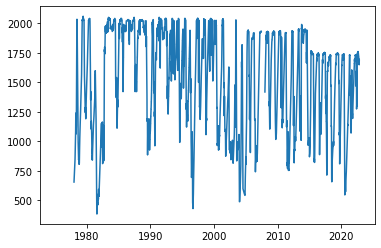

In [123]:
f, ax = plt.subplots()

ax.plot(time, values)